# COS 582 Homework 1
#### Nick Garfield
#### nicholas.garfield@maine.edu
#### 10/10/24

# Web Scraping (Data Collection)
The `requests` library in conjunction with the `furl` library were used to fetch html content from Google Scholar for machine learning articles published after 2022. 

The following cell utilized two key functions: `get_all_articles` and `get_article_data`. The first function used a starting position on Google Scholar's search results page and retrieved a list of elements representing individual research articles. The second function focused on a single article element, extracting its title, publication details, and the number of times it has been cited.

To scrape multiple pages of results, the cell iterated by URL starting position until no article elements were found on the current page. To avoid overloading Google Scholar's servers, a 5-second delay was implemented between requests. Intermediate data were stored as tuples in a list, which upon completion of the loop allowed for easy conversion to a pandas DataFrame. 

In [ ]:
import requests
import furl
import pandas as pd
import time
from bs4 import BeautifulSoup

url = furl.furl("https://scholar.google.com/scholar?start=0&q=machine+learning&hl=en&as_sdt=0,20&as_ylo=2022")

def get_all_articles(start: int):
    url.args["start"] = start
    response = requests.get(
        url=url.url
    )
    soup = BeautifulSoup(response.content, "lxml")
    return soup.find_all("div", class_="gs_ri")

def get_article_data(article):
    title = article.find("h3", class_="gs_rt").get_text(strip=False)
    publication_info = article.find("div", class_="gs_a").get_text(strip=False)
    citation_bar = article.find("div", class_="gs_fl gs_flb").find_all("a")
    cited_by = next((cite.text for cite in citation_bar if "Cited by" in cite.text), None)
    print(title, publication_info, cited_by)
    return title, publication_info, cited_by

raw_data = []
start = 770
all_articles = get_all_articles(start)
while len(all_articles) > 0:
    print(start)
    raw_data = raw_data + [get_article_data(article) for article in all_articles]
    start += 10
    time.sleep(5.)
    all_articles = get_all_articles(start)
    
data = pd.DataFrame(data=raw_data, columns=["title", "publication_info", "cited_by"])
data.to_csv("ml_articles_info.csv", mode="a+")

# Data Wrangling and Exploration
## Data Cleaning
Titles were cleaned using regular expressions to remove any text enclosed in brackets and eliminate extra spaces. This standardization ensured consistency in the title data. 

Publication information was parsed by the `" - "` delimiter to separate out the authors, venue and year, and publisher data. The venue and year string was cleaned with a regular expression to identify two groups: any text, and four consecutive digits such as `2024`.  

Citation data was cleaned with a regular expression to identify any set of consecutive digits in a string formatted like `"Cited By 100"`. 

Any non-conforming rows in the DataFrame were elimited from the dataset. Non-conforming rows included:
* `publication_info` column elements that failed to be delimited by `" - "` into a list of length three. This indicated that the element of the table was missing data for one of: author, venue and year, or publisher. 
* `cited_by` column elements that failed to match a regular expression looking for any number. It was assumed that the string had format `"Cited by ###"`. Failure for the regular expression to find a match indicated a missing quantity. 

In [2]:
import pandas as pd
import re
import datetime

YEAR = datetime.datetime.now().year

data = pd.read_csv("ml_articles_info.csv", index_col = 0)

clean_data = []
for _, row in data.iterrows():
    
    clean_title = re.sub(r"\[.*?\]", "", row["title"]).strip().strip('"')
    
    all_publication_info = str(row["publication_info"]).split(" - ")
    all_publication_info = [element.split("\xa0-") for element in all_publication_info]
    all_publication_info = [item for sublist in all_publication_info for item in sublist]
    try:
        assert len(all_publication_info) == 3
        authors, venue_year, publisher = all_publication_info
        
        match = re.match(r"(.*?)\s+(\d{4})", venue_year)
        if match:
            venue, year = match.groups()
        else:
            venue = re.findall(r"(.*?)\s", venue_year)
            if len(venue) == 0: venue = None
            else: venue = venue[0]
            
            year = re.findall(r"(\d{4})", venue_year)
            if len(year) == 0: year = None
            else: year = int(year[0])
    except AssertionError:
        continue
    
    match = re.findall(r"(\d+)", row["cited_by"])
    if len(match) == 1:
        citation_count = int(match[0])
        citation_per_year = float(citation_count / (int(YEAR) - int(year) + 1))
    else:
        continue
    
    clean_data.append([clean_title, authors, int(year), venue, publisher, int(citation_count), float(citation_per_year)])
    
clean_data = pd.DataFrame(clean_data, columns=["title", "authors", "year", "venue", "publisher", "citation_count", "avg_citations_per_year"])
clean_data.to_csv("ml_articles_info-cleaned.csv")

## Data Exploration
The `pandas` and `matplotlib` packages were used to explore and produce plots for the cleaned dataset. The clean `DataFrame` `"clean_data"` was filtered by the conditions of interest, such as year and citation counts. 

To obtain per-year data, a new `DataFrame` was constructed from an intermediate list dataset that was the result of filtering `"clean_data"` `DataFrame` in conjunction with list comprehension. 

In [87]:
from IPython.display import display

print("Articles published in 2023 or later with a total citation count exceeding 300:")
display(clean_data.loc[(clean_data["citation_count"] > 300) & (clean_data["year"] >= 2023)])

Articles published in 2023 or later with a total citation count exceeding 300:


,title,authors,year,venue,publisher,citation_count,avg_citations_per_year
3,International conference on machine learning,"W Li, C Wang, G Cheng, Q Song",2023,"Transactions on machine learning …,",par.nsf.gov,1568,784.0
8,Probabilistic machine learning: Advanced topics,KP Murphy,2023,None,books.google.com,345,172.5
10,Human-in-the-loop machine learning: a state of...,"E Mosqueira-Rey, E Hernández-Pereira…",2023,"Artificial Intelligence …,",Springer,336,168.0
11,"Machine learning operations (mlops): Overview,...","D Kreuzberger, N Kühl, S Hirschl",2023,"IEEE access,",ieeexplore.ieee.org,399,199.5
27,Understanding of machine learning with deep le...,MM Taye,2023,"Computers,",mdpi.com,315,157.5
31,Fairness in machine learning: A survey,"S Caton, C Haas",2024,"ACM Computing Surveys,",dl.acm.org,641,641.0
46,Coronavirus disease (COVID-19) cases analysis ...,"AS Kwekha-Rashid, HN Abduljabbar, B Alhayani",2023,"Applied Nanoscience,",Springer,328,164.0
75,Artificial intelligence and machine learning i...,"CJ Haug, JM Drazen",2023,"New England Journal of Medicine,",Mass Medical Soc,551,275.5
81,"Artificial intelligence, machine learning and ...","M Soori, B Arezoo, R Dastres",2023,"Cognitive Robotics,",Elsevier,409,204.5
247,Machine learning advances for time series fore...,"RP Masini, MC Medeiros…",2023,"Journal of economic …,",Wiley Online Library,305,152.5


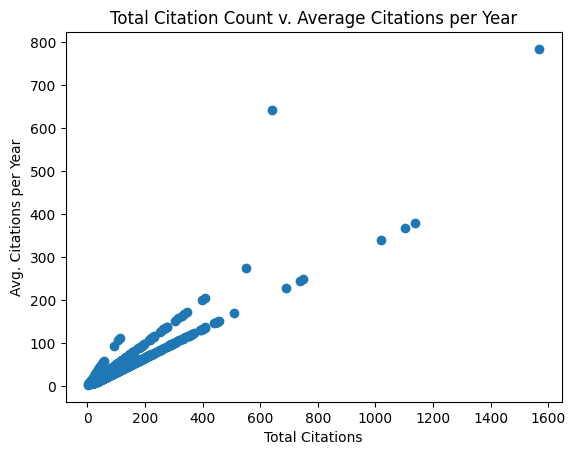

In [4]:
import matplotlib.pyplot as plt

plt.scatter(
    clean_data["citation_count"],
    clean_data["avg_citations_per_year"]
)
plt.title("Total Citation Count v. Average Citations per Year")
plt.xlabel("Total Citations")
plt.ylabel("Avg. Citations per Year")

plt.show()

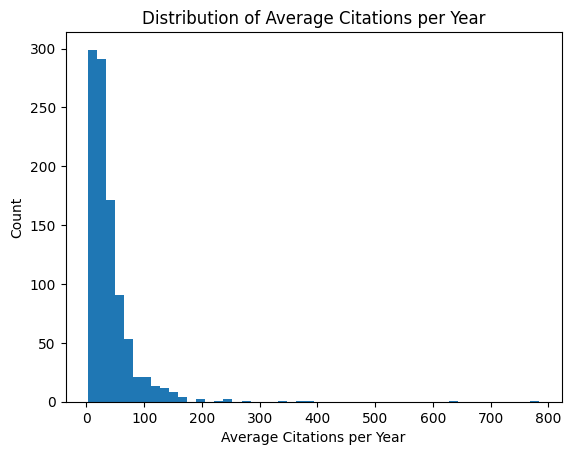

In [26]:
import matplotlib.pyplot as plt

plt.hist(
    clean_data["avg_citations_per_year"],
    bins= 50,
    histtype='bar',
)
plt.xlabel("Average Citations per Year")
plt.ylabel("Count")
plt.title("Distribution of Average Citations per Year")
plt.show()

Number of Articles Published in each Year Since 2022:



,Year,article_count
0,2022,598
1,2023,337
2,2024,60


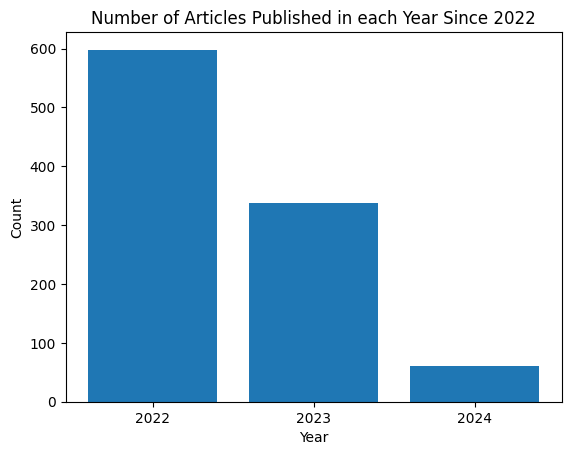

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display
import datetime

years = datetime.datetime.now().year - 2022
years = [2022] + [2022 + i for i in range(1, years + 1)]

article_count = pd.DataFrame(
    [(year, clean_data[clean_data["year"] == year].shape[0]) for year in years],
    columns=["Year", "article_count"]
)

print("Number of Articles Published in each Year Since 2022:\n")
display(article_count)

plt.bar(
    article_count["Year"], height= article_count["article_count"]
)
plt.xticks(years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of Articles Published in each Year Since 2022")
plt.show()


Mean Citation Count of Articles Published in each Year Since 2022:



,Year,total_citations,article_count,mean_citations
0,2022,72773,598,121.693980
1,2023,27226,337,80.789318
2,2024,2392,60,39.866667


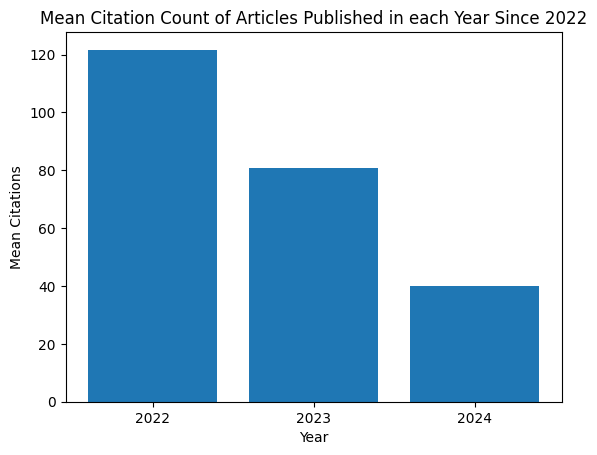

In [18]:
import matplotlib.pyplot as plt
from IPython.display import display
import datetime

years = datetime.datetime.now().year - 2022
years = [2022] + [2022 + i for i in range(1, years + 1)]

total_citations = pd.DataFrame(
    [(year, clean_data[clean_data["year"] == year]["citation_count"].sum()) for year in years],
    columns=["Year", "total_citations"]
).merge(article_count)
total_citations = total_citations.assign(mean_citations= total_citations["total_citations"].divide(total_citations["article_count"]))

print("Mean Citation Count of Articles Published in each Year Since 2022:\n")
display(total_citations)

plt.bar(
    total_citations["Year"], height= total_citations["mean_citations"]
)
plt.xticks(years)
plt.xlabel("Year")
plt.ylabel("Mean Citations")
plt.title("Mean Citation Count of Articles Published in each Year Since 2022")
plt.show()